In [447]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import qutip as qt
import scqubits as scq
import scipy.constants as c
import scipy.optimize as opt

np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Check up fluxonium spectrum

In [2]:
"""Initial set up"""
ECA, EJA, ELA, phi_eA, N_q = 1.5, 4.5, 0.13, 0.0, 4
flux_list = np.linspace(-0.5, 0.5, 101)

In [3]:
"""Fluxonium object and properties for plotting"""
QA = scq.Fluxonium(EC=ECA, EL=ELA, EJ=EJA, flux=phi_eA, cutoff=150, truncated_dim=N_q)
QA_flux_spec = QA.get_spectrum_vs_paramvals("flux", flux_list, evals_count=N_q, subtract_ground=True)
nA_flux   = np.abs(QA.get_matelements_vs_paramvals('n_operator',"flux", flux_list, evals_count=N_q).matrixelem_table)
phiA_flux = np.abs(QA.get_matelements_vs_paramvals('phi_operator',"flux", flux_list, evals_count=N_q).matrixelem_table)

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


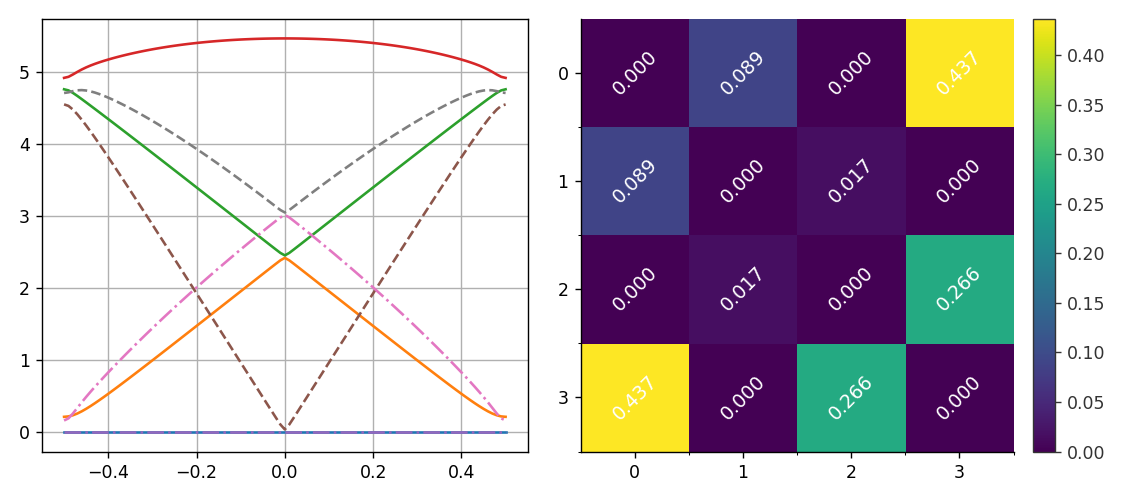

In [4]:
%matplotlib notebook
fig_spec = plt.figure("Q_spec", figsize=(9,4))
ax1_spec = fig_spec.add_subplot(121)
ax2_spec = fig_spec.add_subplot(122)

ax1_spec.plot(flux_list, QA_flux_spec.energy_table)
for i in range(2,N_q):
    ax1_spec.plot(flux_list, QA_flux_spec.energy_table[:,i]-QA_flux_spec.energy_table[:,2], "-.")
    ax1_spec.plot(flux_list, QA_flux_spec.energy_table[:,i]-QA_flux_spec.energy_table[:,1], "--")
for j in range(4,N_q):
    ax1_spec.plot(flux_list, QA_flux_spec.energy_table[:,j]-QA_flux_spec.energy_table[:,3], ".")
ax1_spec.grid()

QA.plot_matrixelements("n_operator", evals_count=N_q, mode='abs', show_numbers=True, show3d=0, fig_ax=(fig_spec, ax2_spec))

plt.tight_layout()

# Pulse shape for time domain simulation

In [449]:
def Gaussian_square(freq, flat, sig, phi_0=0, num_sig=2, time_step=None, norm=True):
    """
    total duration = flat+sig*num_sig*2
    norm: normalize gaussian edge to 0 and 1
    unit: ns
    """
    if time_step==None:
        time_step = 0.1/freq
    t_list = np.linspace(0, flat+sig*num_sig*2, int((flat+sig*num_sig*2)/time_step)+1)
    pulse = np.ones(len(t_list))
    num_step = int(sig*num_sig/time_step)
    
    gauss = np.exp(-(t_list-t_list[0])**2/(2*sig**2))
    edge = gauss[:num_step]
    if norm:
        edge = (edge-edge.min()) / (edge.max()-edge.min())
    pulse[         :num_step] = edge[::-1]
    pulse[-num_step:        ] = edge
    return t_list, pulse*np.cos(2*np.pi*freq*t_list+phi_0)

# Rabi oscillation of fluxonium transition

In [450]:
"""Check bare fluxonium eigenvalue"""
evals = QA.eigenvals(evals_count=N_q)-QA.eigenvals(evals_count=N_q)[0]
H = qt.Qobj(np.diag(evals))
H

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.000000 0.000000 0.000000 0.000000]
 [0.000000 2.420159 0.000000 0.000000]
 [0.000000 0.000000 2.454636 0.000000]
 [0.000000 0.000000 0.000000 5.471613]]

In [451]:
"""Charge drive operator and matrix elements"""
n_opr = qt.Qobj(QA.matrixelement_table('n_operator', evals_count=N_q))
n_opr

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.+1.07655613e-32j 0.-8.90957519e-02j 0.+1.08810227e-14j
  0.-4.36540945e-01j]
 [0.+8.90957519e-02j 0.+1.55928264e-30j 0.+1.69657074e-02j
  0.-3.21634662e-14j]
 [0.-1.08810227e-14j 0.-1.69657074e-02j 0.-1.06609812e-30j
  0.-2.66467976e-01j]
 [0.+4.36540945e-01j 0.+3.21634662e-14j 0.+2.66467976e-01j
  0.-2.80935450e-32j]]

In [452]:
"""Build pulse and estimate Rabi freq with amplitude"""
tlist, pulse = Gaussian_square((evals[3]-evals[0])/(2*np.pi), 100, 50, phi_0=0, num_sig=2, time_step=0.05, norm=True)
amp = 0.2

print(f"# of points: {len(tlist)}", 
      "\nEstimated Rabi frequency:",
      f"\n 0-1: {abs(n_opr[0,1])*amp/(2*np.pi)*1e3:.3f} MHz", 
      f"\n 0-3: {abs(n_opr[0,3])*amp/(2*np.pi)*1e3:.3f} MHz", 
      f"\n 2-3: {abs(n_opr[2,3])*amp/(2*np.pi)*1e3:.3f} MHz"
     )

# of points: 6001 
Estimated Rabi frequency: 
 0-1: 2.836 MHz 
 0-3: 13.896 MHz 
 2-3: 8.482 MHz


<IPython.core.display.Javascript object>


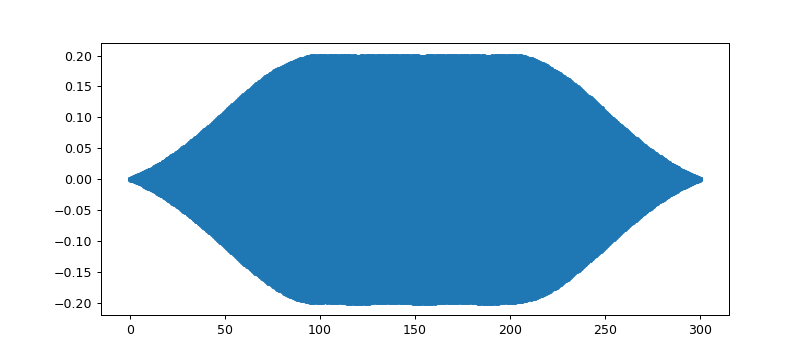

In [453]:
%matplotlib notebook
fig_pulse = plt.figure("pulse shape", figsize=(9,4))
# t, p = Gaussian_square(1, 150, 20, phi_0=0, num_sig=2, norm=True)
plt.plot(tlist, amp*pulse, '.-')

In [291]:
"""Time-dep Hamiltonian and sesolve"""
# evo = qt.QobjEvo([H, [n_opr, pulse]], tlist=tlist)
H_evo = [H, [n_opr, amp*pulse]]
psi0 = qt.basis(N_q, 3)

In [292]:
Rabi_results = qt.sesolve(H_evo, psi0, tlist, 
                          e_ops=[qt.ket2dm(psi0), qt.ket2dm(qt.basis(N_q, 0))]
                         )

(<Figure size 576x288 with 2 Axes>,
 array([[<AxesSubplot:>],
        [<AxesSubplot:xlabel='time'>]], dtype=object))

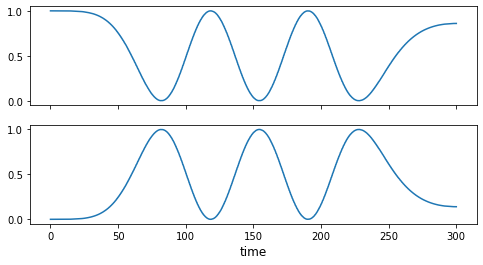

In [293]:
%matplotlib inline
"""quick plot result of expectation values"""
qt.plot_expectation_values(Rabi_results)

Rabi_f = 13.86992 MHz


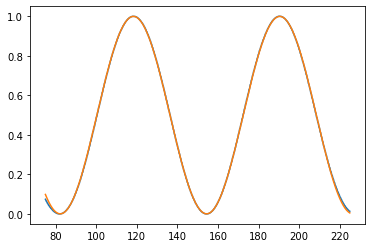

In [294]:
"""Fit Rabi freq"""
start, end = 1500, 4500
fcn = lambda t, t_0, A, A0, f: A*np.sin(2*np.pi*f*(t-t_0))+A0
popt, pcov = opt.curve_fit(fcn, tlist[start:end], Rabi_results.expect[0][start:end], p0=[10, 0.5, +0.5, 0.015])
print(f"Rabi_f = {popt[3]*1e3:.5f} MHz")

plt.plot(tlist[start:end], Rabi_results.expect[0][start:end])
plt.plot(tlist[start:end], fcn(tlist[start:end], *popt))

# Raman driving 0-3 and 2-3
Note: at strong driving amplitude there seems to be leakage to non-computational states. <p>
=> check two tone sweeping

In [470]:
flat, sig, phi_0, time_step = 200, 34.3, 0, 0.02
Rabi_0 = 0.010 * 2*np.pi
Delta  = 0.01414
tlist, pulse_03 = Gaussian_square((evals[3]-evals[0]-Delta)/(2*np.pi), 
                                  flat, sig, phi_0=phi_0, num_sig=2, time_step=time_step, norm=True)
tlist, pulse_23 = Gaussian_square((evals[3]-evals[2]-Delta)/(2*np.pi), 
                                  flat, sig, phi_0=phi_0, num_sig=2, time_step=time_step, norm=True)

In [471]:
amp_03, amp_23 = Rabi_0/abs(n_opr[0,3]), Rabi_0/abs(n_opr[2,3])
# amp_03, amp_23 = 0, Rabi_0/abs(n_opr[2,3])
# amp_03, amp_23 = Rabi_0/abs(n_opr[0,3]), 0
H_evo = [H, [n_opr, amp_03*pulse_03]
          , [n_opr, amp_23*pulse_23]
        ]

In [472]:
psi0 = qt.basis(N_q, 0)
e_ops_list = [qt.ket2dm(qt.basis(N_q, 0)), 
              qt.ket2dm(qt.basis(N_q, 1)), 
              qt.ket2dm(qt.basis(N_q, 2)), 
              qt.ket2dm(qt.basis(N_q, 3))]

In [473]:
Raman_results = qt.sesolve(H_evo, psi0, tlist, 
                           e_ops = e_ops_list, 
                          )

<IPython.core.display.Javascript object>


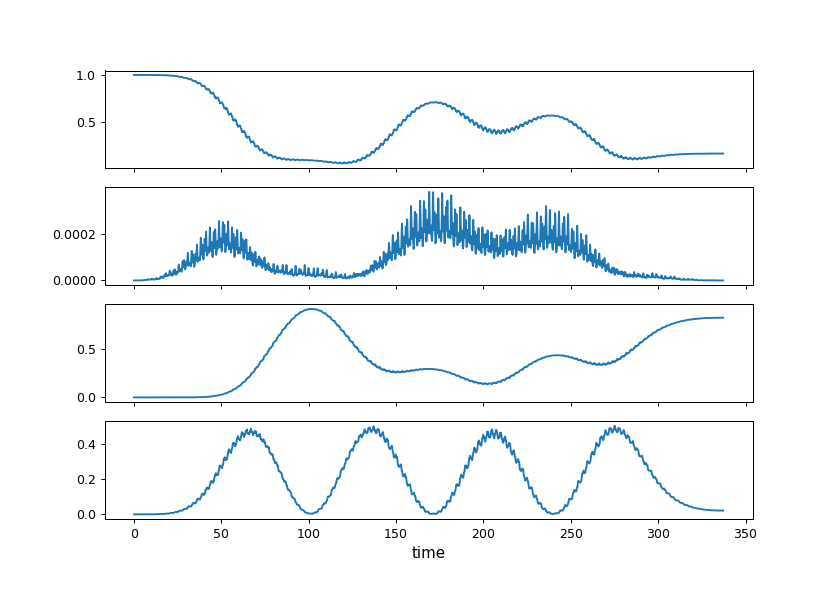

(<Figure size 576x288 with 4 Axes>,
 array([[<AxesSubplot:>],
        [<AxesSubplot:>],
        [<AxesSubplot:>],
        [<AxesSubplot:xlabel='time'>]], dtype=object))

In [474]:
%matplotlib notebook
"""quick plot result of expectation values"""
qt.plot_expectation_values(Raman_results)

<IPython.core.display.Javascript object>


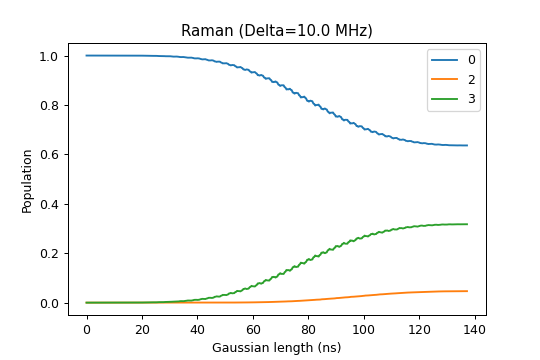

In [446]:
%matplotlib notebook
plt.title(f'Raman (Delta={Delta*1e3:.1f} MHz)')
plt.plot(tlist, Raman_results.expect[0], label='0')
plt.plot(tlist, Raman_results.expect[2], label='2')
plt.plot(tlist, Raman_results.expect[3], label='3')

plt.xlabel("Gaussian length (ns)")
plt.ylabel("Population")
plt.legend()

# STIRAP -- single qubit

In [115]:
def STIRAP_pulse(
    fp, fs, 
    Ap, As,
    td, 
    sig, num_sig=2, 
    phi_d=0, time_step=None, norm=True
):
    """
    total duration = td + sig*num_sig*2
    norm: normalize gaussian edge to 0 and 1
    unit: ns/GHz
    """
    if time_step==None:
        time_step = 0.05/max(fp, fs)
    t_list = np.linspace(0, td+sig*num_sig*2, int((td+sig*num_sig*2)/time_step)+1)
    pump, stoke = np.zeros(len(t_list)), np.zeros(len(t_list))
    num_step = int(2*sig*num_sig/time_step)
    
    gauss_p = np.exp(-(t_list   -sig*num_sig)**2/(2*sig**2))[:num_step ]
    gauss_s = np.exp(-(t_list-td-sig*num_sig)**2/(2*sig**2))[-num_step:]
    
    if norm:
        gauss_p = (gauss_p-gauss_p.min()) / (gauss_p.max()-gauss_p.min())
        gauss_s = (gauss_s-gauss_s.min()) / (gauss_s.max()-gauss_s.min())
        
    pump [         :num_step] = gauss_p
    stoke[-num_step:        ] = gauss_s
    return t_list, Ap*pump*np.cos(2*np.pi*fp*t_list), As*stoke*np.cos(2*np.pi*fs*t_list+phi_0)

<IPython.core.display.Javascript object>


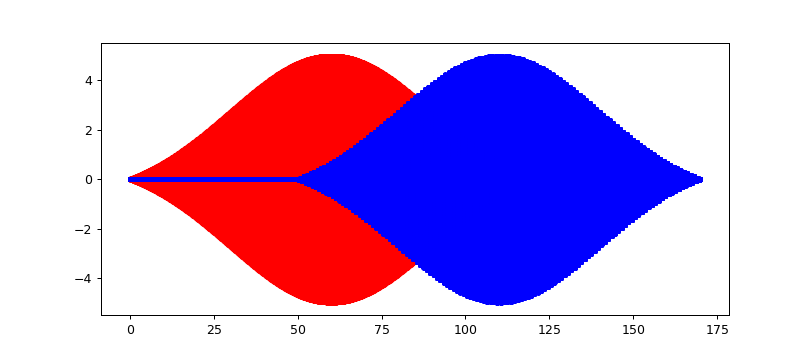

In [173]:
%matplotlib inline
fig_pulse = plt.figure("stirap pulse", figsize=(9,4))
tlist, p, s = STIRAP_pulse(
    fp=12, fs=1, 
    Ap=5, As=5,
    sig=30, 
    td=50, num_sig=2, time_step=None
)
plt.plot(tlist, p, 'r.-')
plt.plot(tlist, s, 'b.-')

In [271]:
td, sig, phi_0, time_step = 30, 30, 0, 0.05
phi_d = 0
Rabi_0 = 0.020*2*np.pi
Delta  = 0.000
amp_03, amp_23 = Rabi_0/abs(n_opr[0,3]), Rabi_0/abs(n_opr[2,3])

tlist, pulse_03, pulse_23 = STIRAP_pulse(
    (evals[3]-evals[2]-Delta)/(2*np.pi), (evals[3]-evals[0]-Delta)/(2*np.pi), 
    amp_03, amp_23,
    td, sig, phi_d=phi_0, num_sig=2, time_step=time_step, norm=True
)
H_evo = [H, [n_opr, pulse_03]
          , [n_opr, pulse_23]
        ]

In [276]:
psi0 = qt.basis(N_q, 0)
e_ops_list = [qt.ket2dm(qt.basis(N_q, 0)), 
              qt.ket2dm(qt.basis(N_q, 1)), 
              qt.ket2dm(qt.basis(N_q, 2)), 
              qt.ket2dm(qt.basis(N_q, 3))]

In [277]:
STIRAP_results = qt.sesolve(H_evo, psi0, tlist, 
                            e_ops = e_ops_list, 
                           )

(<Figure size 576x288 with 4 Axes>,
 array([[<AxesSubplot:>],
        [<AxesSubplot:>],
        [<AxesSubplot:>],
        [<AxesSubplot:xlabel='time'>]], dtype=object))

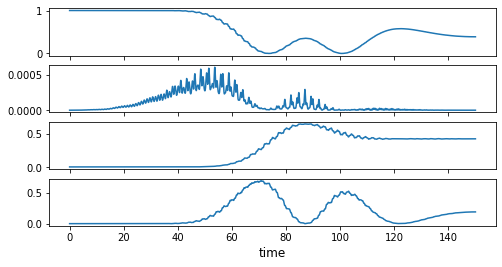

In [278]:
%matplotlib inline
"""quick plot result of expectation values"""
qt.plot_expectation_values(STIRAP_results)

<IPython.core.display.Javascript object>


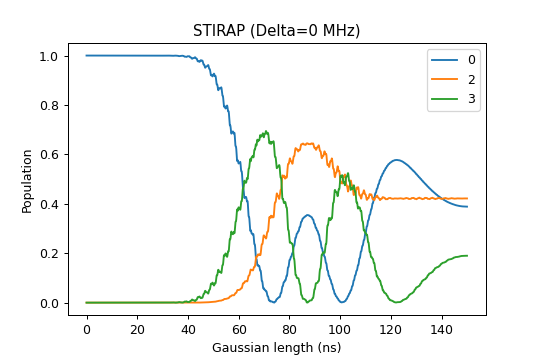

In [279]:
%matplotlib notebook
plt.title('STIRAP (Delta=0 MHz)')
plt.plot(tlist, STIRAP_results.expect[0], label='0')
plt.plot(tlist, STIRAP_results.expect[2], label='2')
plt.plot(tlist, STIRAP_results.expect[3], label='3')

plt.xlabel("Gaussian length (ns)")
plt.ylabel("Population")
plt.legend()

In [283]:
td_list  = np.linspace(10, 30, 11)
pop_list = np.zeros((4, len(td_list)))

In [284]:
for idx, td in enumerate(td_list):
    tlist, pulse_03, pulse_23 = STIRAP_pulse(
        (evals[3]-evals[0]-Delta)/(2*np.pi), (evals[3]-evals[2]-Delta)/(2*np.pi), 
        amp_03, amp_23,
        td, sig, phi_d=phi_0, num_sig=2, time_step=time_step, norm=True
    )
    H_evo = [H, [n_opr, pulse_03]
              , [n_opr, pulse_23]
            ]
    STIRAP_results = qt.sesolve(H_evo, psi0, tlist, 
                                e_ops = e_ops_list, 
                               )
    pop_list[:, idx] = np.array(STIRAP_results.expect)[:,-1]

<IPython.core.display.Javascript object>


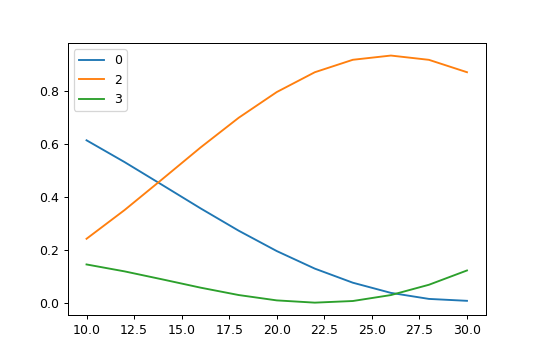

In [285]:
%matplotlib notebook
plt.plot(td_list, pop_list[0,:], label="0")
plt.plot(td_list, pop_list[2,:], label="2")
plt.plot(td_list, pop_list[3,:], label="3")

plt.legend()